# Complaints classification problem using LDA and Random Forest method

This notebook describes an interesting approach to classify the financial complaints to specific issues. Generally, it contains three parts. First, we prepocess the complaints using embedding approaches including removing stop words and stemming words. Then we using embedding method to vercterize every complaints and use the online LDA methods to reduce the dimension. Finally, we use random forest method to deal with the standard classification problem.

 - <a href='#1'>1. Import packages</a>  
 - <a href='#2'>2. Preprocessing</a>
 - <a href='#3'>3. LDA</a>
 - <a href='#4'>4. Random Forest</a>
 - <a href='#5'>5. API</a>
  

## <a id='1'>1. Import packages</a>

In [2]:
import os
import random
import numpy as np
from numpy import asarray
import pandas as pd
import re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
from sklearn.decomposition import NMF, LatentDirichletAllocation
from textblob import TextBlob
from nltk.corpus import stopwords
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
import itertools
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

## <a id='2'>2. Preprossing</a>

Define two functions. One is to convert unstructure colnames to readable colnames. The other is to select the complement data with respect to their traits.

In [3]:
def pythonize_colnames(df):
    df.columns = list(map(lambda each:re.sub('[^0-9a-zA-Z]+', '_', each).lower(), df.columns))
    return (df)
def select_complete_data(df, traits):
    df = df.dropna(subset = traits)
    return (df)

All traits in the datasets are shown below. We select 7 import treats as "Data received date", "Product", "Sub-product", "Issue", "Sub-issue", "Consumer complaint narrative" and "Complaint ID". And we rebuild a dataframe called df_complaints_full. Also the head of this dataframe is shown below.

In [4]:
DATA_FOLDER = os.path.join('..', 'data')
df_consumer_complaints = pd.read_csv(os.path.join(DATA_FOLDER, 'complaints.csv'))
print ("Traits are: {}".format(df_consumer_complaints.columns))
df_complaints_full = df_consumer_complaints[['Date received','Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Complaint ID']]
# pythonize the column names
df_complaints_full = pythonize_colnames(df_complaints_full)
df_complaints_full.head()

Traits are: Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,complaint_id
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,2163100
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,1027760


We select the data whose sub-product is "Checking account" and rebuilt the corresponding dataframe named as df_checking_ac_complaints_complete. You can definitely choose other sub-dataset.

In [5]:
# Only for checking account product 
df_checking_ac_complaints = df_complaints_full.loc[df_complaints_full['sub_product'] == 'Checking account']
traits = ['consumer_complaint_narrative', 'issue', 'sub_issue']
df_checking_ac_complaints_complete = select_complete_data(df_checking_ac_complaints, traits)

## <a id='3'>3. LDA </a>

In this section, we will embedding all narrative into vectors and use online LDA method to reduce the dimension of those vecters as features in the next step. 

We set the word dataset and stop word dataset named as words and stop seperately. The stop word dataset includes the words that are not meaningful in the narratives. Im order to improve the performance of the classification, we need to tune the stop dataset!!!

In [5]:
# Set words and stopwords
words = set(nltk.corpus.words.words())
stop = stopwords.words('english')
stop.extend(['money', 'go', 'without', 'told', 'day', 'one', 'bank', 'account', 'wells fargo', 'wells', 'fargo', 'america','bank of america', 'boa', 'chase', 'citi', 'citibank', 'citi bank', 'suntrust', 'huntington bank', 'pnc', 'citigold', 'navy federal credit union', 'usaa', 'pnc bank', 'first national bank', 'us bank', 'us', 'would'])

We choose the 1000 meaningful words as baisc features. There are some contraints for those words.
First, those words should appear at least twice in the dataset. 
Second, we consider the 3-gram model. It suggests that those word may comprise at most three grams such as "well fargo bank", because some of those n-gram words are very important.  
Third, each gram should be stemmed. 
Then we randomly choose 85% dataset as trainning dataset and remainning 15% as testing dataset

In [6]:
no_features = 1000
# Randomly split training set and testing set
X_train, X_test = train_test_split(df_checking_ac_complaints_complete[['consumer_complaint_narrative', 'issue', 'sub_issue']], test_size=0.15, random_state=42)

# print (X_train.head())
# print (X_test.head())

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, ngram_range=(1,3), max_features=no_features, stop_words=frozenset(stop))
# Preprocess for narratives including stemming
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()
narratives_train = X_train['consumer_complaint_narrative'].map(lambda x: " ".join(re.sub(r'([^a-zA-Z ]+?)', '', " ".join(p_stemmer.stem(w) for w in nltk.wordpunct_tokenize(x) if w.lower() in words and not w.lower() in stop)).split()))
narratives_test = X_test['consumer_complaint_narrative'].map(lambda x: " ".join(re.sub(r'([^a-zA-Z ]+?)', '', " ".join(p_stemmer.stem(w) for w in nltk.wordpunct_tokenize(x) if w.lower() in words and not w.lower() in stop)).split()))

# print (narratives)
tf_train = tf_vectorizer.fit_transform(narratives_train)
tf_test = tf_vectorizer.transform(narratives_test)
tf_feature_names = tf_vectorizer.get_feature_names()
# print (tf_feature_names)

This part is optimal. It is used to select the optimal number of topics in LDA model based on the perplexity of the test dataset. However, it doesn't make much sence due to the one paper form Chang 2009.

In [7]:
for i in range(8, 12):
    lda = LatentDirichletAllocation(n_topics=i, max_iter=5, learning_method='online', learning_offset=64.,random_state=0).fit(tf_train)
    train_gamma = lda.transform(tf_test)
    train_perplexity = lda.perplexity(tf_test, train_gamma)
    print(str(i), ':', str(train_perplexity))

/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:812: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if doc_topic_distr != 'deprecated':
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:816: DeprecationWarning: Argument 'doc_topic_distr' is deprecated and is being ignored as of 0.19. Support for this argument will be removed in 0.21.
  DeprecationWarning)


8 : 628.3283111165834


/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:816: DeprecationWarning: Argument 'doc_topic_distr' is deprecated and is being ignored as of 0.19. Support for this argument will be removed in 0.21.
  DeprecationWarning)


9 : 643.5687211523843


/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:816: DeprecationWarning: Argument 'doc_topic_distr' is deprecated and is being ignored as of 0.19. Support for this argument will be removed in 0.21.
  DeprecationWarning)


10 : 655.6841065260987


/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:816: DeprecationWarning: Argument 'doc_topic_distr' is deprecated and is being ignored as of 0.19. Support for this argument will be removed in 0.21.
  DeprecationWarning)


11 : 660.5185357249626


We select the LDA model with 10 topics. And train the LDA model using training dataset and tranform training data and testing data to vectors as lda_D_train and lda_D_test

In [8]:
lda = LatentDirichletAllocation(n_topics=10, max_iter=5, learning_method='online', learning_offset=64.,random_state=0).fit(tf_train)
# words per topic
lda_T = lda.components_
# topics per document_
lda_D_train = lda.transform(tf_train)
lda_D_test = lda.transform(tf_test)

/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Since we choose 10 topics, we select the top 5 most likely words in each topics. You can find some topics are meaningful. For example, the second topic "fraud,inform,branch,report,person" suggests that this complaint may relate to the fraud. and the third topic "block,need,simpl,discov,consum", suggests that this complaint may related to the block of account. However, the 8th topic "get,back,said,call,tri" seems to be used to state a fact, which doesn't provided much inforamation directly.
However, if we jointly consider the information of all topics, it will give me amazing information.

In [9]:
no_top_words = 5
for topic_idx, topic in enumerate(lda_T):
    print (",".join([tf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

deposit,direct,bonu,branch,receiv
fraud,inform,branch,report,person
block,need,simpl,discov,consum
receiv,letter,provid,inform,complaint
credit,credit card,feder,card,navi
check,fund,hold,transfer,avail
card,claim,debit,debit card,transact
get,back,said,call,tri
overdraft,fee,balanc,charg,transact
close,pay,balanc,fee,time


In [10]:
# def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
#     for topic_idx, topic in enumerate(H):
#         print ("Topic %d:" % (topic_idx))
#         print (" ".join([feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]))
#         top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
#         for doc_index in top_doc_indices:
#             print (documents.iloc[doc_index,])

# lda_W = lda.transform(tf)
# lda_H = lda.components_

# no_top_words = 5
# no_top_documents = 2
# display_topics(lda_H, lda_W, tf_feature_names, X_train['consumer_complaint_narrative'], no_top_words, no_top_documents)

Provide the top 5 high-probability words for each topic.

In [10]:
dct_topics = {"0": "deposit,direct,bonu,branch,receiv",
"1": "fraud,inform,branch,report,person",
"2": "block,need,simpl,discov,consum",
"3": "receiv,letter,provid,inform,complaint",
"4": "credit,credit card,feder,card,navi",
"5": "check,fund,hold,transfer,avail",
"6": "card,claim,debit,debit card,fraud",
"7": "get,back,said,call,tri",
"8": "overdraft,fee,balanc,charg,transact",
"9": "close,pay,balanc,fee,time"}

#### Predictions using single topic information

If we only use a single opic information for prediction, the results doesn't make much sense. The results are shown as below. There, we use compute the polarity and subjectivity traits for each complaints. Thoes two complaints could be considered in the following random forest algorithm. For simplicity, I didn't consider these two traits. If you are interested in both traits you can simply put them as feature in the random forest algorithm.

In [11]:
X_train['Polarity'] = [TextBlob(doc).sentiment[0] for doc in list(X_train['consumer_complaint_narrative'])]
X_train['Subjectivity'] = [TextBlob(doc).sentiment[1] for doc in list(X_train['consumer_complaint_narrative'])]

X_test['Topic'] = [dct_topics[str(lda_D_test[idx, :].argmax())] for idx in range(0, X_test.shape[0])]
X_test['Polarity'] = [TextBlob(doc).sentiment[0] for doc in list(X_test['consumer_complaint_narrative'])]
X_test['Subjectivity'] = [TextBlob(doc).sentiment[1] for doc in list(X_test['consumer_complaint_narrative'])]
X_test.head()

,consumer_complaint_narrative,issue,sub_issue,Topic,Polarity,Subjectivity
849900,USBank allowed my ex husband to fraudulently o...,Opening an account,Account opened as a result of fraud,"fraud,inform,branch,report,person",-0.069585,0.367512
967968,My husband and I have had a joint account at P...,Problem caused by your funds being low,Overdrafts and overdraft fees,"fraud,inform,branch,report,person",0.016532,0.167742
907684,My personal check was refused at XXXX XXXX eve...,Managing an account,Problem making or receiving payments,"get,back,said,call,tri",-0.133333,0.333333
971822,It 's beyond any human being to imagine the to...,Closing an account,Funds not received from closed account,"get,back,said,call,tri",0.028432,0.452938
938113,I lodged a complaint few days back to CFPB. Th...,Managing an account,Banking errors,"deposit,direct,bonu,branch,receiv",-0.111111,0.355556


#### Explore the issues and subissues

We simply group issues and sub-issues based on the datasets

In [13]:
X_train.groupby(['issue']).size()

issue
Closing an account                                                                   540
Credit monitoring or identity theft protection services                                2
Improper use of your report                                                            6
Incorrect information on your report                                                  19
Managing an account                                                                 2616
Opening an account                                                                   565
Problem caused by your funds being low                                               570
Problem with a credit reporting company's investigation into an existing problem       3
Problem with a lender or other company charging your account                         548
Unable to get your credit report or credit score                                       2
dtype: int64

In [67]:
X_test.groupby(['issue']).size()

issue
Closing an account                                                                  116
Incorrect information on your report                                                  6
Managing an account                                                                 431
Opening an account                                                                  104
Problem caused by your funds being low                                              106
Problem with a credit reporting company's investigation into an existing problem      1
Problem with a lender or other company charging your account                         96
dtype: int64

In [14]:
X_train.groupby(['sub_issue']).size()

sub_issue
Account information incorrect                                                              4
Account opened as a result of fraud                                                       92
Account status incorrect                                                                   5
Banking errors                                                                           328
Billing dispute for services                                                               1
Bounced checks or returned payments                                                       43
Can't close your account                                                                  98
Can't stop withdrawals from your account                                                  61
Cashing a check                                                                           98
Company closed your account                                                              294
Confusing or missing disclosures                            

In [69]:
X_test.groupby(['sub_issue']).size()

sub_issue
Account information incorrect                                                              3
Account opened as a result of fraud                                                       20
Account status incorrect                                                                   2
Banking errors                                                                            44
Bounced checks or returned payments                                                        3
Can't close your account                                                                  23
Can't stop withdrawals from your account                                                   8
Cashing a check                                                                           16
Company closed your account                                                               60
Confusing or missing disclosures                                                           2
Deposits and withdrawals                                    

## <a id='4'>4. Random Forest</a>

#### Prediction for issues

This part, we use the random forest method as a standard classification problem. We classify the complaints into the issues. In this part, we choose the number of topics as 10. Also, this number of topics can be tuned. For convenience, I didn't tune this parameter. But definitely this parameter is pretty important for the performance of the classification problem. If you want to get better performance, you definitely need to use cross validation method to choose the best parameter.

In [15]:
n_features = 10

lda = LatentDirichletAllocation(n_topics=n_features, max_iter=5, learning_method='online', learning_offset=64.,random_state=0).fit(tf_train)

# words per topic
lda_T = lda.components_
# topics per document_
lda_D_train = lda.transform(tf_train)
lda_D_test = lda.transform(tf_test)

/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state = 42)
clf.fit(lda_D_train, X_train['issue'])
y_categories = clf.classes_

issue_preds = clf.predict_proba(lda_D_train)
issue_predictions = np.array([", ".join(y_categories[issue_pred.argsort()[-3:]]) for issue_pred in issue_preds])
# print (y_categories)
X_train["predicted_issue"] = issue_predictions

issue_preds = clf.predict_proba(lda_D_test)
issue_predictions = np.array([", ".join(y_categories[issue_pred.argsort()[-3:]]) for issue_pred in issue_preds])
# print (y_categories)
X_test["predicted_issue"] = issue_predictions

We show the predicted issue results here.

In [17]:
X_test.head()

,consumer_complaint_narrative,issue,sub_issue,Topic,Polarity,Subjectivity,predicted_issue
849900,USBank allowed my ex husband to fraudulently o...,Opening an account,Account opened as a result of fraud,"fraud,inform,branch,report,person",-0.069585,0.367512,Problem with a lender or other company chargin...
967968,My husband and I have had a joint account at P...,Problem caused by your funds being low,Overdrafts and overdraft fees,"fraud,inform,branch,report,person",0.016532,0.167742,Problem with a lender or other company chargin...
907684,My personal check was refused at XXXX XXXX eve...,Managing an account,Problem making or receiving payments,"get,back,said,call,tri",-0.133333,0.333333,Problem with a lender or other company chargin...
971822,It 's beyond any human being to imagine the to...,Closing an account,Funds not received from closed account,"get,back,said,call,tri",0.028432,0.452938,"Closing an account, Problem with a lender or o..."
938113,I lodged a complaint few days back to CFPB. Th...,Managing an account,Banking errors,"deposit,direct,bonu,branch,receiv",-0.111111,0.355556,"Closing an account, Managing an account, Openi..."


We compute accuracy of prediction. we find that if we choose top three likely predicted issue, it has 90.1% probability that the true issue is belong to the predicted issues.

In [18]:
num_matched = 0
for i in range(X_test.shape[0]):
    if X_test.iloc[i, 1] in X_test.iloc[i, -1].split(", ")[:1]:
        num_matched += 1
# print(num_matched)
print ("Select one results, accuracy: {}".format(num_matched/X_test.shape[0]))
num_matched = 0
for i in range(X_test.shape[0]):
    if X_test.iloc[i, 1] in X_test.iloc[i, -1].split(", ")[:2]:
        num_matched += 1
# print(num_matched)
print ("Select two results, accuracy: {}".format(num_matched/X_test.shape[0]))
num_matched = 0
for i in range(X_test.shape[0]):
    if X_test.iloc[i, 1] in X_test.iloc[i, -1].split(", ")[:3]:
        num_matched += 1
# print(num_matched)
print ("Select three results, accuracy: {}".format(num_matched/X_test.shape[0]))

Select one results, accuracy: 0.1186046511627907
Select two results, accuracy: 0.3732558139534884
Select three results, accuracy: 0.9011627906976745


#### Prediction for subissues

The same idea can be implenmented to the prediction for subissues.

In [13]:
def LDA(n_features):
    lda = LatentDirichletAllocation(n_topics=n_features, max_iter=5, learning_method='online', learning_offset=64.,random_state=0).fit(tf_train)

    # words per topic
    lda_T = lda.components_
    # topics per document_
    lda_D_train = lda.transform(tf_train)
    lda_D_test = lda.transform(tf_test)
    return (lda_D_train, lda_D_test)

def RF(train_features, test_features, pred_name = "issue", n_comp = 3):
    clf = RandomForestClassifier(n_estimators=200, random_state = 42)
    clf.fit(train_features, X_train[pred_name])
    y_categories = clf.classes_

    issue_preds = clf.predict_proba(train_features)
    issue_predictions = np.array([", ".join(y_categories[issue_pred.argsort()[-n_comp:]]) for issue_pred in issue_preds])
    # print (y_categories)
    X_train["predicted_" + pred_name] = issue_predictions

    issue_preds = clf.predict_proba(test_features)
    issue_predictions = np.array([", ".join(y_categories[issue_pred.argsort()[-n_comp:]]) for issue_pred in issue_preds])
    # print (y_categories)
    X_test["predicted_" + pred_name] = issue_predictions
    num_matched = 0
#     for i in range(X_test.shape[0]):
#         if X_test.iloc[i, 2] in X_test.iloc[i, -1].split(", ")[:1]:
#             num_matched += 1
#     # print(num_matched)
#     print ("Select one results, accuracy: {}".format(num_matched/X_test.shape[0]))
#     num_matched = 0
#     for i in range(X_test.shape[0]):
#         if X_test.iloc[i, 2] in X_test.iloc[i, -1].split(", ")[:2]:
#             num_matched += 1
#     # print(num_matched)
#     print ("Select two results, accuracy: {}".format(num_matched/X_test.shape[0]))
#     num_matched = 0
#     for i in range(X_test.shape[0]):
#         if X_test.iloc[i, 2] in X_test.iloc[i, -1].split(", ")[:3]:
#             num_matched += 1
#     # print(num_matched)
#     print ("Select three results, accuracy: {}".format(num_matched/X_test.shape[0]))
    num_matched = 0
    for i in range(X_test.shape[0]):
        if X_test.iloc[i, 2] in X_test.iloc[i, -1].split(", "):
            num_matched += 1
    accuracy = num_matched/X_test.shape[0]
    return(accuracy)

def Prediction(n_features, pred_name = "issue", do_sentiment = False, n_comp = 3):
    lda_D_train, lda_D_test = LDA(n_features)
    if do_sentiment:
        train_features = np.concatenate([lda_D_train, X_train['Polarity'].values.reshape(-1,1), X_train['Subjectivity'].values.reshape(-1,1)], axis = 1)
        test_features = np.concatenate([lda_D_test, X_test['Polarity'].values.reshape(-1,1), X_test['Subjectivity'].values.reshape(-1,1)], axis = 1)
    else:
        train_features = lda_D_train
        test_features = lda_D_test
    accuracy = RF(train_features, test_features, pred_name, n_comp)
    return(accuracy)

def Prediction_probs(n_features, pred_name = "issue", do_sentiment=False):
    lda_D_train, lda_D_test = LDA(n_features)
    if do_sentiment:
        train_features = np.concatenate([lda_D_train, X_train['Polarity'].values.reshape(-1,1), X_train['Subjectivity'].values.reshape(-1,1)], axis = 1)
        test_features = np.concatenate([lda_D_test, X_test['Polarity'].values.reshape(-1,1), X_test['Subjectivity'].values.reshape(-1,1)], axis = 1)
    else:
        train_features = lda_D_train
        test_features = lda_D_test
    clf = RandomForestClassifier(n_estimators=200, random_state = 42)
    clf.fit(train_features, X_train[pred_name])
    y_categories = clf.classes_
    issue_preds = clf.predict_proba(test_features)
    return(y_categories, issue_preds)

##### Accuracy plot

We do a bunch of experiments about the prediction accuracy based on different settings of parameters

First, we ananlysis that if the sentiment trait significantly affects the prediction accuracy.

In [71]:
accuracy_list_sentiment = [Prediction(i, "sub_issue", do_sentiment=True, n_comp = 3) for i in range(10,20)]
accuracy_list_no_sentiment = [Prediction(i, "sub_issue", do_sentiment=False, n_comp = 3) for i in range(10,20)]


/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_compone

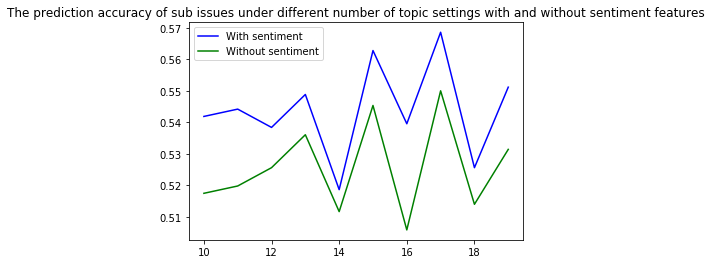

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(10,20), accuracy_list_sentiment, 'b', label = "With sentiment")
plt.plot(np.arange(10,20), accuracy_list_no_sentiment, 'g', label = "Without sentiment")
plt.legend(loc = 0)
plt.title("The prediction accuracy of sub issues under different number of topic settings with and without sentiment features")
plt.show()


The prediction accuracy plot suggests the sentiment traits significantly contribute to better prediction results. So we would include the sentiment traits in the following analysis.

Second, we analysis the accuracy plot for different number of prediction components

In [65]:
accuracy_mat = np.zeros([10, 7])
for n_comp in range(3,10):
    accuracy_mat[:,(n_comp - 3)] = np.array([Prediction(i, "sub_issue", do_sentiment=True, n_comp= n_comp) for i in range(10,20)])


/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_compone

/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_compone

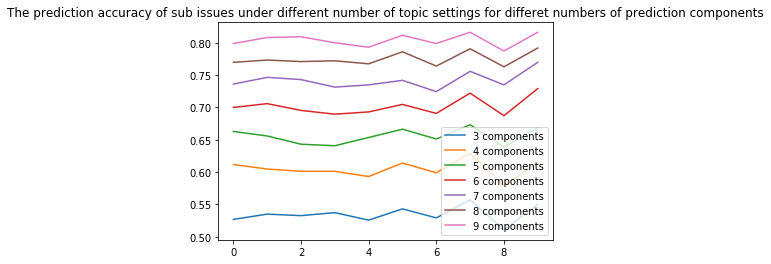

In [66]:
fig = plt.figure()
plt.plot(accuracy_mat)
plt.legend(("3 components", "4 components", "5 components", "6 components", "7 components", "8 components", "9 components", "10 components"), loc = 0)
plt.title("The prediction accuracy of sub issues under different number of topic settings for differet numbers of prediction components")
plt.show()

#### Hierarchical model for the prediction of subissues

#### Version 1

Compute the probability vectors for issues and subissues

In [14]:
issue_names, issue_pred_probs = Prediction_probs(10, pred_name="issue", do_sentiment=True)
subissue_names, subissue_pred_probs = Prediction_probs(10, pred_name="sub_issue", do_sentiment=True)

/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Since there is a full mapping between subissues and issues, we assume the joint distribution of subissue and issue for certain complaint is $p(issue, subissue) \propto \hat{p}(issue)\hat{p}(subissue)1(subissue \in issue)$
Compute the joint probability vectors.

In [16]:
group_subissue_issue = X_train.groupby(['sub_issue', 'issue'])
dict_subissue_issue =  dict(list(group_subissue_issue.groups.keys()))
subissue_issue_names = [dict_subissue_issue[subissue_name] for subissue_name in subissue_names]
def issue2subissue(issue_pred_prob, issue_names=issue_names, subissue_issue_names=subissue_issue_names):
    subissue_issue_prob = [issue_pred_prob[subissue_issue_name == issue_names] for subissue_issue_name in subissue_issue_names]
    return (np.array(subissue_issue_prob).reshape(-1))

subissue_issue_pred_probs = [subissue_pred_prob * issue2subissue(issue_pred_prob) for subissue_pred_prob, issue_pred_prob in zip(subissue_pred_probs, issue_pred_probs)]
subissue_issue_pred_probs = np.array(subissue_issue_pred_probs)

# print(issue_names)
# print(subissue_names)
# print(subissue_issue_names)
# print(dict_subissue_issue)

print(subissue_issue_pred_probs[0])
print(issue2subissue(issue_pred_probs[0]))

def Pure_prediction(issue_names, pred_probs, n_comp = 3):
    issue_predictions = np.array([", ".join(issue_names[pred_prob.argsort()[-n_comp:]]) for pred_prob in pred_probs])
    num_matched = 0
    for i in range(X_test.shape[0]):
        if X_test.iloc[i, 2] in issue_predictions[i].split(", "):
            num_matched += 1
    accuracy = num_matched/X_test.shape[0]
    return(accuracy)

print (Pure_prediction(subissue_names, subissue_pred_probs))
print (Pure_prediction(subissue_names, subissue_issue_pred_probs))


[0.000e+00 3.750e-02 0.000e+00 9.180e-02 0.000e+00 2.500e-05 1.575e-03
 0.000e+00 4.050e-02 2.100e-03 0.000e+00 0.000e+00 5.940e-02 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 5.400e-03 5.250e-04 1.000e-04 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.500e-05 1.890e-02 0.000e+00
 1.080e-02 7.020e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.175e-03
 3.875e-02 0.000e+00]
[0.005 0.25  0.005 0.54  0.    0.005 0.105 0.095 0.54  0.105 0.25  0.
 0.54  0.25  0.    0.54  0.105 0.54  0.105 0.005 0.005 0.095 0.005 0.005
 0.    0.005 0.54  0.    0.54  0.54  0.005 0.    0.    0.    0.095 0.25
 0.   ]
0.5395348837209303
0.5151162790697674


This part suggests in the training process, combining information between issue and subissue does not make strong improvement for the prediction of subissues.

#### version 2

Since random forest method does not have true probability meaning, we select need to do more analysis about the distribution of predictive probabilities. The histogram of the probability that random forest shows the complains belongs to the top 3 categories is shown as following: 

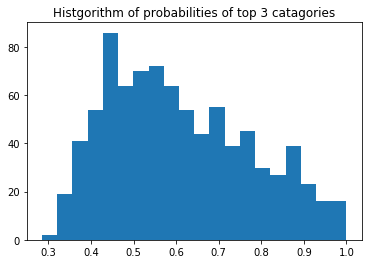

In [45]:
import matplotlib.pyplot as plt
def Hist_top_n(pred_probs, top_n = 3):
    n = len(pred_probs)
    prob_vec = np.zeros(n)
    for i in range(n):
        prob_vec[i] = np.sum(np.sort(pred_probs[i])[-top_n:])
    fig = plt.figure()
    plt.hist(prob_vec, bins=20)
    plt.title("Histgorithm of probabilities of top {} catagories".format(top_n))
    plt.show()
    return (prob_vec)
probs_top_3 = Hist_top_n(subissue_pred_probs)

Check the predictive accuracy for "Easy group":

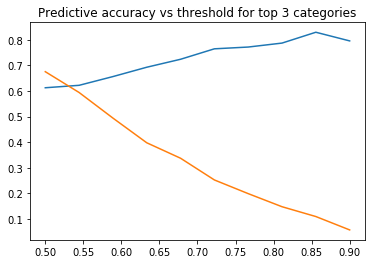

In [47]:
def Pure_prediction(issue_names, pred_probs, top_n = 3, threshold = 0.6):
    issue_predictions = np.array([", ".join(issue_names[pred_prob.argsort()[-top_n:]]) for pred_prob in pred_probs])
    num_matched = 0
    num_total = 0
    for i in range(X_test.shape[0]):
        if np.sum(np.sort(pred_probs[i])[-top_n:]) > threshold:
            num_total += 1
            if X_test.iloc[i, 2] in issue_predictions[i].split(", "):
                num_matched += 1
    accuracy = num_matched/num_total
    return(accuracy)

Pure_prediction(subissue_names, subissue_pred_probs)
threshold_list = np.linspace(0.5, 0.9, 10)
top_n = 3
accuracy_list = np.array([Pure_prediction(subissue_names, subissue_pred_probs, threshold = threshold) for threshold in threshold_list])
percentage_list = np.array([np.mean(probs_top_3 > threshold) for threshold in threshold_list])
fig = plt.figure()
plt.plot(threshold_list, accuracy_list)
plt.plot(threshold_list, percentage_list)

plt.title("Predictive accuracy vs threshold for top {} categories".format(top_n))
plt.show()


## <a id='5'>5. API</a>

In [39]:
issue = ['Closing an account', 'Managing an account', 'Opening an account']
subissue = ['Banking errors', 'Money was taken from your account on the wrong day or for the wrong amount', 'Funds not received from closed account', 'Unable to open an account', 'Funds not handled or disbursed as instructed', 'Transaction was not authorized', 'Problem using a debit or ATM card', 'Company closed your account', 'Deposits and withdrawals', 'Account opened as a result of fraud']
subissue_issue = ['Managing an account', 'Problem with a lender or other company charging your account', 'Closing an account', 'Opening an account', 'Managing an account', 'Problem with a lender or other company charging your account', 'Managing an account', 'Closing an account', 'Managing an account', 'Opening an account']

issue = np.array(issue)
subissue = np.array(subissue)
subissue_issue = np.array(subissue_issue)


temp = []
for iss in issue:
    temp.append(", ".join(subissue[subissue_issue == iss]))
temp = "; ".join(temp)

temp

'Funds not received from closed account, Company closed your account; Banking errors, Funds not handled or disbursed as instructed, Problem using a debit or ATM card, Deposits and withdrawals; Unable to open an account, Account opened as a result of fraud'

In [40]:
def LDA(n_features, tf_train, tf_test):
    lda = LatentDirichletAllocation(n_topics=n_features, max_iter=5, learning_method='online', learning_offset=64.,random_state=0).fit(tf_train)

    # words per topic
    lda_T = lda.components_
    # topics per document_
    lda_D_train = lda.transform(tf_train)
    lda_D_test = lda.transform(tf_test)
    return (lda_D_train, lda_D_test)

def Prediction_probs(n_features, X_train, tf_train, X_test, tf_test, pred_name = "issue", do_sentiment=False):
    lda_D_train, lda_D_test = LDA(n_features,tf_train, tf_test)
    if do_sentiment:
        train_features = np.concatenate([lda_D_train, X_train['Polarity'].values.reshape(-1,1), X_train['Subjectivity'].values.reshape(-1,1)], axis = 1)
        test_features = np.concatenate([lda_D_test, X_test['Polarity'].values.reshape(-1,1), X_test['Subjectivity'].values.reshape(-1,1)], axis = 1)
    else:
        train_features = lda_D_train
        test_features = lda_D_test
    clf = RandomForestClassifier(n_estimators=500, random_state = 42) ###
    clf.fit(train_features, X_train[pred_name])
    y_categories = clf.classes_
    issue_preds = clf.predict_proba(test_features)
    return(y_categories, issue_preds)

def Classify(issues, subissues, dict_subissue_issue):
    res = []
    for issue, subissue in zip(issues, subissues):
        issue = np.array(issue.split(", "))
        subissue = np.array(subissue.split(", "))
        subissue_issue = np.array([dict_subissue_issue[subiss] for subiss in subissue])
        temp = []
        for iss in issue:
            temp.append(", ".join(subissue[subissue_issue == iss]))
        temp = "; ".join(temp)
        res.append(temp)
    return res
    
def get_prdicted_topics_and_sentiments(complaints_data, new_data = []): # This API is just for demo. So we use whole dataset as train data
    # Set words and stopwords
    words = set(nltk.corpus.words.words())
    stop = stopwords.words('english')
    stop.extend(['money', 'go', 'without', 'told', 'day', 'one', 'bank', 'account', 'wells fargo', 'wells', 'fargo', 'america','bank of america', 'boa', 'chase', 'citi', 'citibank', 'citi bank', 'suntrust', 'huntington bank', 'pnc', 'citigold', 'navy federal credit union', 'usaa', 'pnc bank', 'first national bank', 'us bank', 'us', 'would'])
    no_features = 1000
    # Randomly split training set and testing set
    X_train, X_test = train_test_split(complaints_data[['consumer_complaint_narrative', 'issue', 'sub_issue']], test_size=0.15, random_state=42)
    
    # overwrite X_train
    X_train = complaints_data
    if len(new_data) > 0:
        X_test = pd.DataFrame({'consumer_comlpaint_narrative': new_data})
    
    # print (X_train.head())
    # print (X_test.head())

    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, ngram_range=(1,3), max_features=no_features, stop_words=frozenset(stop))
    # Preprocess for narratives including stemming
    from nltk.stem.porter import PorterStemmer
    p_stemmer = PorterStemmer()
    narratives_train = X_train['consumer_complaint_narrative'].map(lambda x: " ".join(re.sub(r'([^a-zA-Z ]+?)', '', " ".join(p_stemmer.stem(w) for w in nltk.wordpunct_tokenize(x) if w.lower() in words and not w.lower() in stop)).split()))
    narratives_test = X_test['consumer_complaint_narrative'].map(lambda x: " ".join(re.sub(r'([^a-zA-Z ]+?)', '', " ".join(p_stemmer.stem(w) for w in nltk.wordpunct_tokenize(x) if w.lower() in words and not w.lower() in stop)).split()))

    # print (narratives)
    tf_train = tf_vectorizer.fit_transform(narratives_train)
    tf_test = tf_vectorizer.transform(narratives_test)
    tf_feature_names = tf_vectorizer.get_feature_names()
    # print (tf_feature_names)

    X_train['Polarity'] = [TextBlob(doc).sentiment[0] for doc in list(X_train['consumer_complaint_narrative'])]
    X_train['Subjectivity'] = [TextBlob(doc).sentiment[1] for doc in list(X_train['consumer_complaint_narrative'])]
    X_test['Polarity'] = [TextBlob(doc).sentiment[0] for doc in list(X_test['consumer_complaint_narrative'])]
    X_test['Subjectivity'] = [TextBlob(doc).sentiment[1] for doc in list(X_test['consumer_complaint_narrative'])]
    
    issue_names, issue_pred_probs = Prediction_probs(10, X_train, tf_train, X_test, tf_test, pred_name="issue", do_sentiment=True)
    subissue_names, subissue_pred_probs = Prediction_probs(10, X_train, tf_train, X_test, tf_test, pred_name="sub_issue", do_sentiment=True)
    
    issue_predictions = np.array([", ".join(issue_names[issue_pred.argsort()[-3:]]) for issue_pred in issue_pred_probs])
    X_test["predicted_issue"] = issue_predictions
    
    subissue_predictions = np.array([", ".join(subissue_names[subissue_pred.argsort()[-10:]]) for subissue_pred in subissue_pred_probs])
#     X_test["predicted_subissue"] = subissue_predictions
    
    
    group_subissue_issue = X_train.groupby(['sub_issue', 'issue'])
    dict_subissue_issue =  dict(list(group_subissue_issue.groups.keys()))
 
    classified_subissue_predictions = Classify(issue_predictions, subissue_predictions, dict_subissue_issue)
    X_test["predicted_subissue"] = classified_subissue_predictions
    
    return(X_test)
    


In [41]:
X_test = get_prdicted_topics_and_sentiments(df_checking_ac_complaints_complete)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/rui/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics

In [47]:
X_test.head()

,consumer_complaint_narrative,issue,sub_issue,Polarity,Subjectivity,predicted_issue,predicted_subissue
849900,USBank allowed my ex husband to fraudulently o...,Opening an account,Account opened as a result of fraud,-0.069585,0.367512,"Closing an account, Managing an account, Openi...","Funds not received from closed account, Compan..."
967968,My husband and I have had a joint account at P...,Problem caused by your funds being low,Overdrafts and overdraft fees,0.016532,0.167742,Problem with a lender or other company chargin...,"Transaction was not authorized, Can't stop wit..."
907684,My personal check was refused at XXXX XXXX eve...,Managing an account,Problem making or receiving payments,-0.133333,0.333333,Problem with a lender or other company chargin...,"; Funds not received from closed account, Comp..."
971822,It 's beyond any human being to imagine the to...,Closing an account,Funds not received from closed account,0.028432,0.452938,Problem with a lender or other company chargin...,Transaction was not authorized; Problem making...
938113,I lodged a complaint few days back to CFPB. Th...,Managing an account,Banking errors,-0.111111,0.355556,"Closing an account, Opening an account, Managi...","Funds not received from closed account, Compan..."


In [58]:
X_test.iloc[1,1]

'Problem caused by your funds being low'

In [57]:
X_test.iloc[1,5]

'Problem with a lender or other company charging your account, Managing an account, Problem caused by your funds being low'

In [60]:
X_test.iloc[1,2]

'Overdrafts and overdraft fees'

In [61]:
X_test.iloc[1,6]

"Transaction was not authorized, Can't stop withdrawals from your account; Problem using a debit or ATM card, Banking errors, Cashing a check, Funds not handled or disbursed as instructed, Deposits and withdrawals; Bounced checks or returned payments, Overdrafts and overdraft fees"